In [3]:
import duckdb

# In-memory DB
con = duckdb.connect()

con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")

con.execute("SET s3_region='ap-south-1';")

In [4]:
result = con.execute("""
SELECT COUNT(*) 
FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
""").fetchall()

print(result)

[(15901854,)]


In [5]:
sql = """
WITH ranked AS (
  SELECT
    court,
    COUNT(*) AS cases_disposed
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
  )
  WHERE
    year BETWEEN 2019 AND 2022
    AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
  GROUP BY court
)
SELECT court, cases_disposed
FROM ranked
ORDER BY cases_disposed DESC
LIMIT 1
"""

In [6]:
top_court = con.execute(sql).df()
print(top_court) 

  court  cases_disposed
0  9_13          817786


{"Which high court disposed the most cases from 2019 - 2022?": "9_13", "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": "nan", "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": ""}

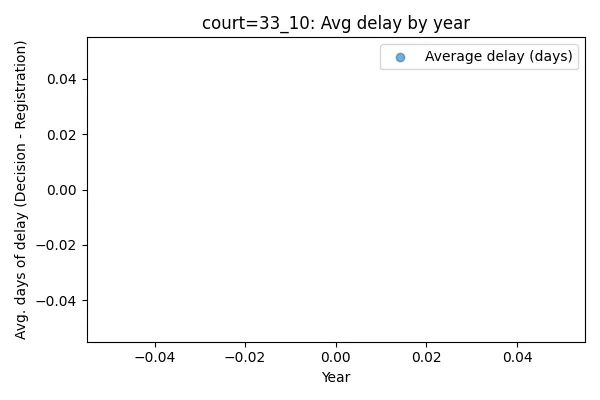

In [ ]:
# pip install duckdb matplotlib numpy pandas

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import json

# --- Connect & prepare DuckDB ---
con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # bucket is public

# --- 1) High court with most disposals (2019–2022) ---
most_cases_df = con.execute("""
SELECT court, COUNT(*) AS cases_disposed
FROM read_parquet(
  's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
WHERE year BETWEEN 2019 AND 2022
  AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
GROUP BY court
ORDER BY cases_disposed DESC
LIMIT 1
""").df()

most_cases_court = most_cases_df.iloc[0]["court"] if not most_cases_df.empty else None

# --- 2) Regression slope of (decision_date - date_of_registration) by YEAR for court=33_10 ---
# We compute per-year average delay (days), then regress avg_delay ~ year
delay_by_year = con.execute("""
WITH delays AS (
  SELECT
    year,
    DATE_DIFF('day', TRY_CAST(date_of_registration AS DATE), decision_date) AS delay_days
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=33_10/bench=*/metadata.parquet'
  )
  WHERE date_of_registration IS NOT NULL
    AND decision_date IS NOT NULL
)
SELECT
  year,
  AVG(delay_days) AS avg_delay_days
FROM delays
WHERE delay_days IS NOT NULL
GROUP BY year
ORDER BY year
""").df()

if len(delay_by_year) >= 2:
  x = delay_by_year["year"].to_numpy(dtype=float)
  y = delay_by_year["avg_delay_days"].to_numpy(dtype=float)
  slope, intercept = np.polyfit(x, y, 1)
  slope_val = float(slope)
else:
  slope_val = float("nan")  # not enough points

# --- 3) Scatterplot (year vs avg delay) with dotted red regression line ---
fig = plt.figure(figsize=(6, 4))
plt.scatter(delay_by_year["year"], delay_by_year["avg_delay_days"], alpha=0.6, label="Average delay (days)")
if len(delay_by_year) >= 2:
  xx = np.linspace(delay_by_year["year"].min(), delay_by_year["year"].max(), 200)
  yy = slope_val * xx + intercept
  plt.plot(xx, yy, "r:", label="Regression line")
plt.xlabel("Year")
plt.ylabel("Avg. days of delay (Decision - Registration)")
plt.title("court=33_10: Avg delay by year")
plt.legend()
plt.tight_layout()

buf = BytesIO()
fig.savefig(buf, format="webp")  # compact, stays well under 100k chars
plt.close(fig)
img_b64 = base64.b64encode(buf.getvalue()).decode("ascii")
data_uri = f"data:image/webp;base64,{img_b64}"

# --- 4) Emit JSON result ---
result = {
  "Which high court disposed the most cases from 2019 - 2022?": str(most_cases_court),
  "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": str(slope_val),
  "Plot the year and # of days of delay from the above question as a scatterplot with a regression line. Encode as a base64 data URI under 100,000 characters": data_uri
}

print(json.dumps(result, ensure_ascii=False))

In [26]:
slope_val
delay_by_year


,year,avg_delay_days


In [9]:
# pip install duckdb pandas

import duckdb
import pandas as pd
import json

# Connect to DuckDB (in-memory). Use duckdb.connect("mydb.duckdb") to persist.
con = duckdb.connect()

# Enable S3/Parquet support
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # public bucket region

# Query: court with most disposals between 2019 and 2022
sql_top = """
SELECT court, COUNT(*) AS cases_disposed
FROM read_parquet(
  's3://indian-high-court-judgments/metadata/parquet/year=*/court=*/bench=*/metadata.parquet'
)
WHERE year BETWEEN 2019 AND 2022
  AND decision_date BETWEEN DATE '2019-01-01' AND DATE '2022-12-31'
GROUP BY court
ORDER BY cases_disposed DESC
LIMIT 1
"""

top_df = con.execute(sql_top).df()

# Also get the full ranking (optional)
sql_full = sql_top.replace("LIMIT 1", "")
full_df = con.execute(sql_full).df()

# Print answers
top_court = None if top_df.empty else top_df.iloc[0]["court"]
print("Top court (2019–2022):", top_court)

# If you want JSON output:
result = {
    "Which high court disposed the most cases from 2019 - 2022?": None if top_df.empty else {
        "court": top_df.iloc[0]["court"],
        "cases_disposed": int(top_df.iloc[0]["cases_disposed"])
    }
}
print(json.dumps(result, ensure_ascii=False, indent=2))

# (Optional) Show full ranking as a table
# print(full_df.head(25).to_string(index=False))

Top court (2019–2022): 9_13
{
  "Which high court disposed the most cases from 2019 - 2022?": {
    "court": "9_13",
    "cases_disposed": 817786
  }
}


In [34]:
# pip install duckdb pandas numpy

import duckdb
import numpy as np
import pandas as pd

# Connect
con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # public bucket

# Query: average delay per year for court=33_10
delay_by_year = con.execute("""
WITH delays AS (
  SELECT
    year,
    DATE_DIFF('day', TRY_CAST(TRY_STRPTIME(date_of_registration, '%d-%m-%Y') AS DATE), decision_date) AS delay_days
  FROM read_parquet(
    's3://indian-high-court-judgments/metadata/parquet/year=*/court=33_10/bench=*/metadata.parquet'
  )
  WHERE date_of_registration IS NOT NULL
    AND decision_date IS NOT NULL
)
SELECT
  year,
  AVG(delay_days) AS avg_delay_days
FROM delays
WHERE delay_days IS NOT NULL
GROUP BY year
ORDER BY year
""").df()

# Regression: avg_delay_days ~ year
if len(delay_by_year) >= 2:
    x = delay_by_year["year"].to_numpy(dtype=float)
    y = delay_by_year["avg_delay_days"].to_numpy(dtype=float)
    slope, intercept = np.polyfit(x, y, 1)
    slope_val = float(slope)
else:
    slope_val = float("nan")

print({
    "What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": slope_val
})

{"What's the regression slope of the date_of_registration - decision_date by year in the court=33_10?": -21.07628484290379}


In [14]:
len(delay_by_year)

0

In [32]:
# pip install duckdb pandas

import duckdb
import pandas as pd
import json

# Connect to DuckDB (in-memory). Use duckdb.connect("mydb.duckdb") to persist.
con = duckdb.connect()

# Enable S3/Parquet support
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("SET s3_region='ap-south-1';")  # public bucket region

# Query: court with most disposals between 2019 and 2022
sql_top = """
SELECT date_of_registration,
       decision_date,
       DATE_DIFF('day', TRY_CAST(TRY_STRPTIME(date_of_registration, '%d-%m-%Y') AS DATE), decision_date) AS delay_days
FROM read_parquet(
  's3://indian-high-court-judgments/metadata/parquet/year=*/court=33_10/bench=*/metadata.parquet?s3_region=ap-south-1'
)
LIMIT 10;
"""

top_df = con.execute(sql_top).df()

In [33]:
top_df

,date_of_registration,decision_date,delay_days
0,01-01-1995,1995-12-14,347
1,01-01-1992,1996-12-06,1801
2,01-01-1988,1996-05-08,3050
3,01-01-1997,1997-07-29,209
4,23-05-2000,1999-01-25,-484
5,30-04-1998,2000-07-11,803
6,08-12-1987,2000-04-30,4527
7,29-11-2000,2000-01-12,-322
8,01-01-2000,2000-12-19,353
9,01-01-1999,2000-08-17,594
